In [1]:
%reload_ext autoreload
%autoreload 2

# Load the data

In [6]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
pairs_to_process = [(10, 10), (20, 20), (30, 35), (40, 35), (55, 35)]

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]

# Load results

In [7]:
import json

with open("../results/softInfo_vs_informed.json", "r") as f:
    decoding_results = json.load(f)

print(decoding_results)

{'cnn25s724wx0008f9kz0': [{'decoding': 'grid', 'num_errors': 2}, {'decoding': 'kde', 'num_errors': 0, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'informed', 'num_errors': 0}, {'decoding': 'kde_relError', 'num_errors': 0, 'additional_info': {'rel_error': -1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'kde_bandwidth', 'num_errors': 0, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.6, 0.7, 1], 'num_points_bandwidths': 2}}], 'cn6hm589recg008x0jvg': [{'decoding': 'grid', 'num_errors': 1}, {'decoding': 'kde', 'num_errors': 0, 'additional_info': {'rel_error': 1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'informed', 'num_errors': 3}, {'decoding': 'kde_relError', 'num_errors': 0, 'additional_info': {'rel_error': -1, 'bandwidth_linspace': [0.4, 0.7, 20], 'num_points_bandwidths': 51}}, {'decoding': 'kde_bandwidth', 'num_errors': 0,

# Get the cummulative error dict

In [8]:
pairs_to_process = [(10, 10), (20, 20), (30, 35), (40, 35), (55, 35)]

err_rates_dict = {pair: [{}, 0] for pair in pairs_to_process}
for index, row in md.iterrows():
    if (row["distance"], row["rounds"]) not in pairs_to_process:
        continue
    decoding_result = decoding_results[row["job_id"]]
    
    # add the shots to the total
    err_rates_dict[(row["distance"], row["rounds"])][1] += row["shots"]

    # add the errors to the dictionary
    for decoding_entry in decoding_result:
        if decoding_entry["decoding"] not in err_rates_dict[(row["distance"], row["rounds"])][0]:
            err_rates_dict[(row["distance"], row["rounds"])][0][decoding_entry["decoding"]] = decoding_entry["num_errors"]
        else:
            err_rates_dict[(row["distance"], row["rounds"])][0][decoding_entry["decoding"]] += decoding_entry["num_errors"]

print(err_rates_dict)

{(10, 10): [{'grid': 115, 'kde': 104, 'informed': 133, 'kde_relError': 107, 'kde_bandwidth': 115}, 50000.0], (20, 20): [{'grid': 4, 'kde': 2, 'informed': 10, 'kde_relError': 2, 'kde_bandwidth': 3}, 5000.0], (30, 35): [{'grid': 32, 'kde': 10, 'informed': 133, 'kde_relError': 12, 'kde_bandwidth': 13}, 15391.0], (40, 35): [{'grid': 11, 'kde': 4, 'informed': 51, 'kde_relError': 3, 'kde_bandwidth': 2}, 10621.0], (55, 35): [{'grid': 3, 'kde': 0, 'informed': 4, 'kde_relError': 0, 'kde_bandwidth': 0}, 7596.0]}


# Plot

(dist, T): (10, 10)
informed err_rate: 0.00266
kde err_rate: 0.00208

(dist, T): (20, 20)
informed err_rate: 0.002
kde err_rate: 0.0004

(dist, T): (30, 35)
informed err_rate: 0.008641413813267494
kde err_rate: 0.0006497303618998116

(dist, T): (40, 35)
informed err_rate: 0.004801807739384239
kde err_rate: 0.00037661237171641087

(dist, T): (55, 35)
informed err_rate: 0.000526592943654555
kde err_rate: 0.0



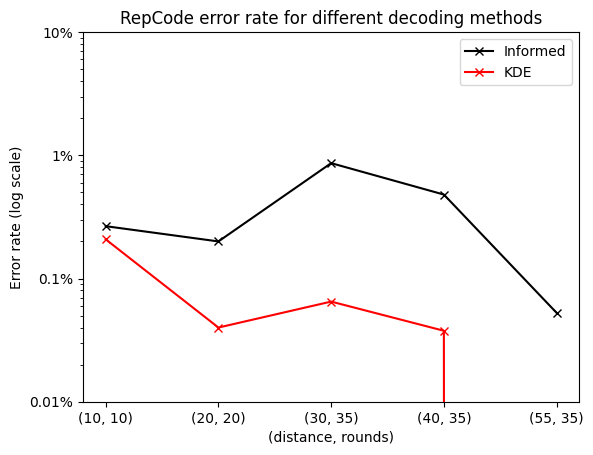

In [10]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []
for pair, (err_rates, shots) in err_rates_dict.items():
    err_rates = {key: value / shots for key, value in err_rates.items()}
    print("(dist, T):", pair)
    print("informed err_rate:", err_rates['informed'])
    print("kde err_rate:", err_rates['kde'])
    print()

    err_rates_informed.append(err_rates['informed'])
    err_rates_kde.append(err_rates['kde'])

plt.plot([str(pair) for pair in pairs_to_process], err_rates_informed, label="Informed", marker='x', color='black')
plt.plot([str(pair) for pair in pairs_to_process], err_rates_kde, label="KDE", marker='x', color='red')
plt.yscale('log')
plt.yticks(ticks=[0.0001, 0.001, 0.01, 0.1], labels=["0.01%", "0.1%", "1%", "10%"])
plt.ylabel('Error rate (log scale)')
plt.xlabel('(distance, rounds)')
plt.title('RepCode error rate for different decoding methods')
plt.legend()




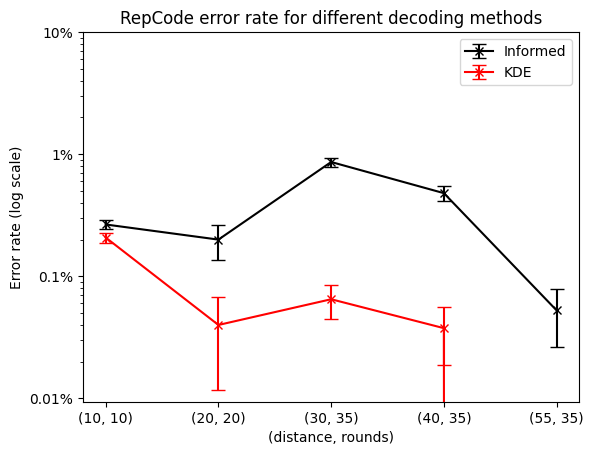

In [11]:
import matplotlib.pyplot as plt
import numpy as np

err_rates_informed = []
err_rates_kde = []
errors_informed = []
errors_kde = []

for pair, (err_rates, shots) in err_rates_dict.items():
    err_rates_calculated = {key: value / shots for key, value in err_rates.items()}
    error_informed = np.sqrt(err_rates['informed']) / shots
    error_kde = np.sqrt(err_rates['kde']) / shots
    # error_kde = np.sqrt(err_rates['kde']/shots*(1-err_rates["kde"]/shots)/shots)

    
    err_rates_informed.append(err_rates_calculated['informed'])
    err_rates_kde.append(err_rates_calculated['kde'])
    
    errors_informed.append(error_informed)
    errors_kde.append(error_kde)

plt.errorbar([str(pair) for pair in pairs_to_process], err_rates_informed, yerr=errors_informed, label="Informed", marker='x', color='black', fmt='-', capsize=5)
plt.errorbar([str(pair) for pair in pairs_to_process], err_rates_kde, yerr=errors_kde, label="KDE", marker='x', color='red', fmt='-', capsize=5)

plt.yscale('log')
plt.yticks(ticks=[0.0001, 0.001, 0.01, 0.1], labels=["0.01%", "0.1%", "1%", "10%"])
plt.ylabel('Error rate (log scale)')
plt.xlabel('(distance, rounds)')
plt.title('RepCode error rate for different decoding methods')
plt.legend()

plt.show()



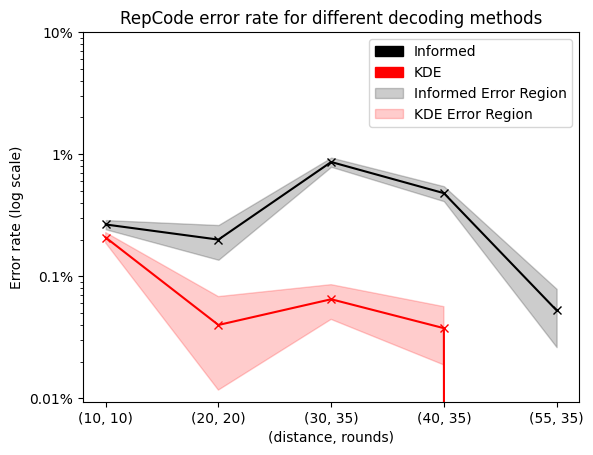

In [13]:
import matplotlib.patches as mpatches

# Calculate upper and lower bounds for error regions
upper_informed = np.array(err_rates_informed) + np.array(errors_informed)
lower_informed = np.array(err_rates_informed) - np.array(errors_informed)
upper_kde = np.array(err_rates_kde) + np.array(errors_kde)
lower_kde = np.array(err_rates_kde) - np.array(errors_kde)

# Plot error bars for informed and KDE
plt.plot([str(pair) for pair in pairs_to_process], err_rates_informed, label="Informed", marker='x', color='black')
plt.plot([str(pair) for pair in pairs_to_process], err_rates_kde, label="KDE", marker='x', color='red')

# Add fill_between for error regions
plt.fill_between([str(pair) for pair in pairs_to_process], lower_informed, upper_informed, color='black', alpha=0.2)
plt.fill_between([str(pair) for pair in pairs_to_process], lower_kde, upper_kde, color='red', alpha=0.2)

# Create custom patches for the legend
informed_patch = mpatches.Patch(color='black', label='Informed Error Region', alpha=0.2)
kde_patch = mpatches.Patch(color='red', label='KDE Error Region', alpha=0.2)

# Add the error bar legends along with the custom patches
plt.legend(handles=[mpatches.Patch(color='black', label='Informed'), mpatches.Patch(color='red', label='KDE'), informed_patch, kde_patch])

plt.yscale('log')
plt.yticks(ticks=[0.0001, 0.001, 0.01, 0.1], labels=["0.01%", "0.1%", "1%", "10%"])
plt.ylabel('Error rate (log scale)')
plt.xlabel('(distance, rounds)')
plt.title('RepCode error rate for different decoding methods')

plt.show()

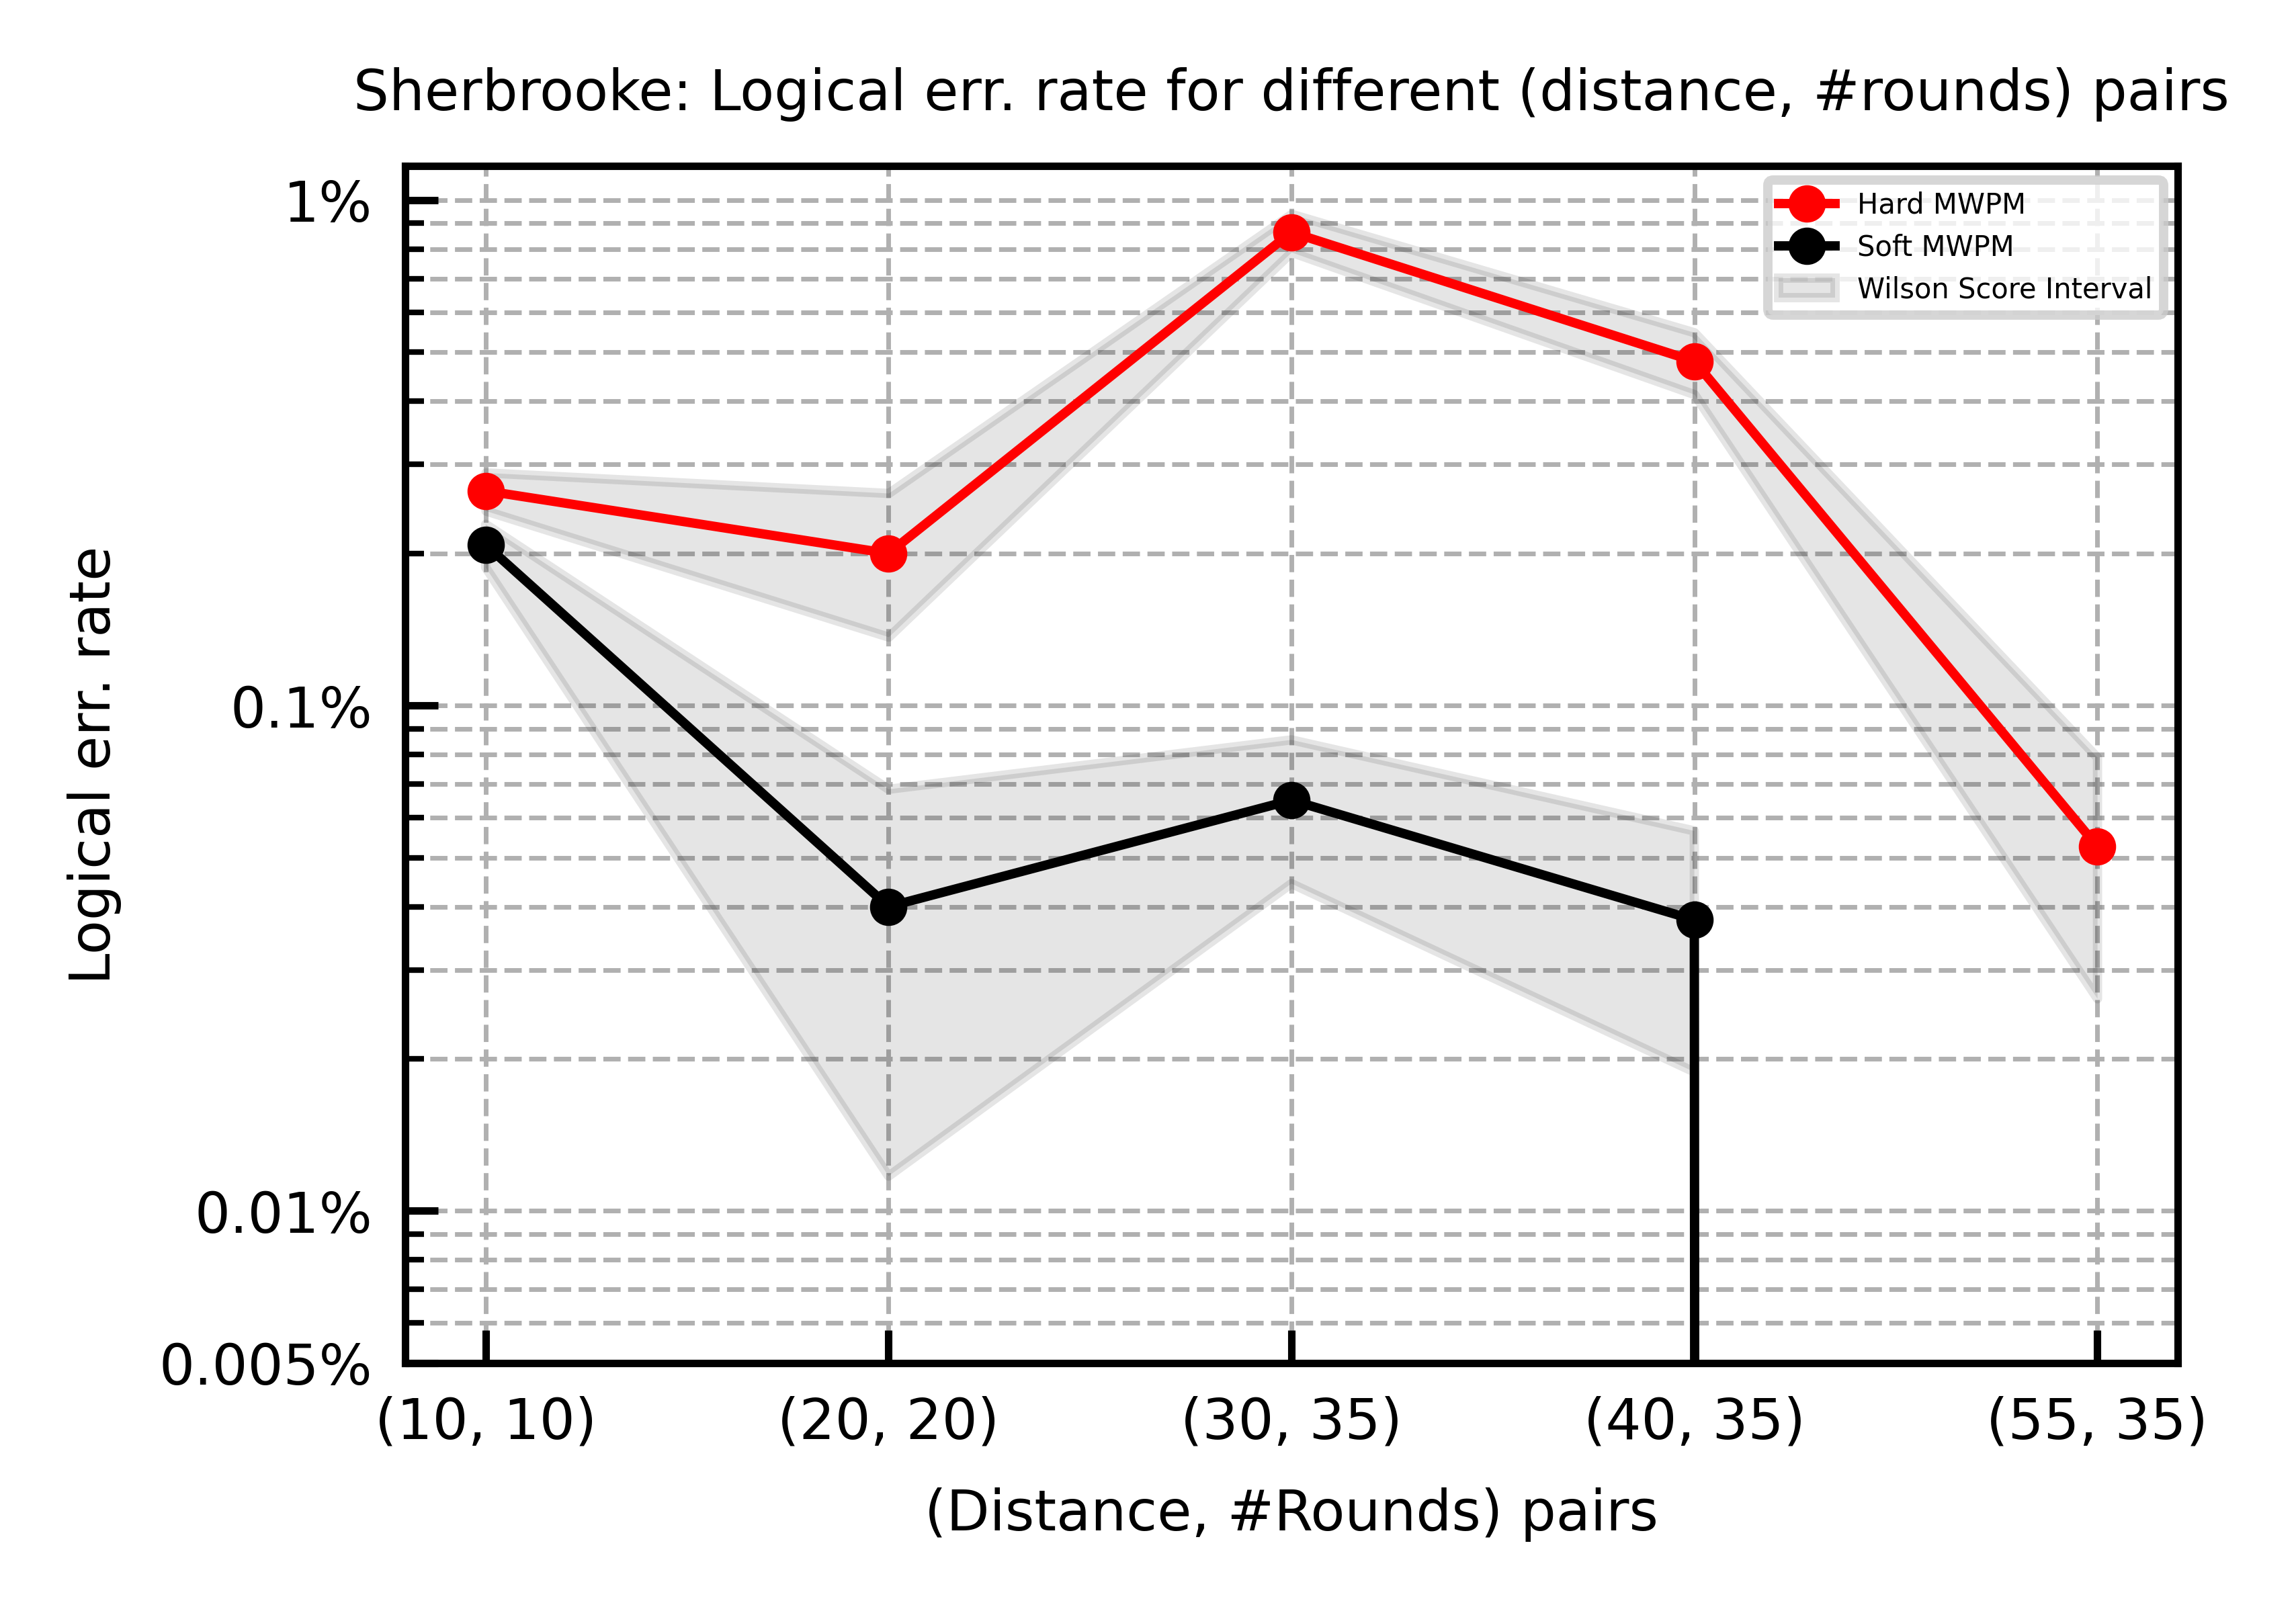

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))*1.1
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))*1.1

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 1000,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : True,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize'     : font_size,
    'axes.labelsize'      : font_size,
    'axes.titlesize'      : font_size,
    'xtick.labelsize'     : font_size,
    'ytick.labelsize'     : font_size,
})


plt.rcParams.update({'font.family':'sans-serif'})

# Calculate and plot error rates and their regions
err_rates_informed = []
err_rates_kde = []
errors_informed = []
errors_kde = []

for pair, (err_rates, shots) in err_rates_dict.items():
    err_rates_calculated = {key: value / shots for key, value in err_rates.items()}
    error_informed = np.sqrt(err_rates['informed']) / shots
    error_kde = np.sqrt(err_rates['kde']) / shots
    
    err_rates_informed.append(err_rates_calculated['informed'])
    err_rates_kde.append(err_rates_calculated['kde'])
    errors_informed.append(error_informed)
    errors_kde.append(error_kde)

# Calculate upper and lower bounds for error regions
upper_informed = np.array(err_rates_informed) + np.array(errors_informed)
lower_informed = np.array(err_rates_informed) - np.array(errors_informed)
upper_kde = np.array(err_rates_kde) + np.array(errors_kde)
lower_kde = np.array(err_rates_kde) - np.array(errors_kde)

# Plot the central lines and error regions
plt.plot([str(pair) for pair in pairs_to_process], err_rates_informed, 'o-', label="Hard MWPM", color='red', markersize=3, linewidth=1)
plt.fill_between([str(pair) for pair in pairs_to_process], lower_informed, upper_informed, color='black', alpha=0.1)

plt.plot([str(pair) for pair in pairs_to_process], err_rates_kde, 'o-', label="Soft MWPM", color='black', markersize=3, linewidth=1)
plt.fill_between([str(pair) for pair in pairs_to_process], lower_kde, upper_kde, color='black', alpha=0.1)

# Legend
# informed_line = mpatches.Patch(color='black', label='Informed')
# kde_line = mpatches.Patch(color='red', label='KDE')
# informed_error_patch = mpatches.Patch(color='black', alpha=0.1, label='Informed Error Region')
# kde_error_patch = mpatches.Patch(color='red', alpha=0.1, label='KDE Error Region')
# plt.legend(handles=[informed_line, kde_line, informed_error_patch, kde_error_patch], fontsize=3)
error_patch = mpatches.Patch(color='black', alpha=0.1, label='Error Region')

current_handles, current_labels = plt.gca().get_legend_handles_labels()
current_handles.append(error_patch)  # Append the error_patch to the existing handles
plt.legend(handles=current_handles, labels=current_labels + ['Wilson Score Interval'], fontsize=3)

plt.yscale('log')
plt.yticks(ticks=[0.00005, 0.0001, 0.001, 0.01], labels=["0.005%", "0.01%", "0.1%", "1%"], fontsize=6)
# plt.xticks(err_rates_dict.keys(), rotation=45, ha="right", fontsize=4)
plt.ylabel("Logical err. rate")
plt.xlabel("(Distance, #Rounds) pairs")
plt.title("Sherbrooke: Logical err. rate for different (distance, #rounds) pairs")
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()
